In [1]:
%matplotlib inline
import loompy
import logging
import pandas as pd
import numpy as np
import cytograph as cg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import *
from sklearn.metrics.pairwise import cosine_distances
import numpy_groupies as npg
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sparse
import networkx as nx
import community
from sklearn.manifold import TSNE
import umap

2018-07-14 21:49:06,865 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [6]:
import loompy
import numpy as np

#f = 'my_data.loom'
f = "/Users/stelin/build_20171205/L1_Sympathetic_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f, 'r') as ds:
    cg_exp = ds.map([np.count_nonzero], axis=0)[0]
    genes = cg_exp > 2
    for (ix, selection, view) in ds.scan(axis=1):
        loompy.create_append('gene_filtered_ds2.loom', view.layers[genes, :], view.ra[genes], view.ca)


TypeError: create_append() missing 2 required positional arguments: 'row_attrs' and 'col_attrs'

In [2]:
f = "/Users/stelin/build_20171205/L1_MidbrainDorsal.loom"
with loompy.connect(f) as ds:
    #print(type(ds.col_graphs.KNN))
    ne = cg.NeighborhoodEnrichment()
    ne.fit_loom(ds)


OSError: Can't read data (inflate() failed)

In [ ]:
f = "/Users/stelin/build_20171205/L1_MidbrainDorsal.loom"
with loompy.connect(f) as ds:
    gene = "Itpr2"
    gix = np.where(ds.ra.Gene == gene)[0][0]
    em = "TSNE"
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    color = ds[gix, :]
    plt.scatter(ds.ca[em][:,0],ds.ca[em][:,1],s=50,lw=0,vmin=np.percentile(color, 5),vmax=np.percentile(color, 95),marker='.',c=color)
    plt.subplot(132)
    
#   color = ds.layer["enrichment"][gix, :]
#   plt.scatter(ds.ca[em][:,0],ds.ca[em][:,1],s=50,lw=0,vmin=np.percentile(color, 5),vmax=np.percentile(color, 95),marker='.',c=color)
#   plt.subplot(133)

    ne = cg.NeighborhoodEnrichment(epsilon=0.00001)
    knn_matrix = ds.col_graphs.KNN.tocsr()
    k = knn_matrix.count_nonzero() / knn_matrix.shape[0]
    gix = np.where(ds.ra.Gene == gene)[0][0]
    color=ne.fit(ds[gix, :], knn_matrix, k)
    plt.scatter(ds.ca[em][:,0],ds.ca[em][:,1],s=50,lw=0,vmin=np.percentile(color, 5),vmax=np.percentile(color, 95),marker='.',c=color,cmap="viridis")


In [49]:
knn = sparse.csr_matrix(np.array([[1,1,0],[0,1,1],[1,0,1]]))
X = np.array([2,3,7])
nonzeros = (X > 0).astype('int')
knn.multiply(X).todense()

matrix([[2, 3, 0],
        [0, 3, 7],
        [2, 0, 7]], dtype=int64)

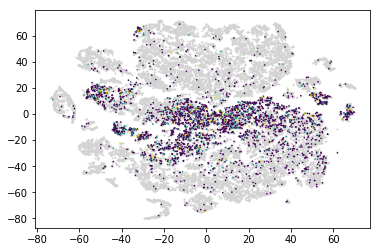

In [80]:
f = "/Users/stelin/build_20171205/L1_ForebrainDorsal_E12-15_nfactors=100_k=25_ksmoothing=250_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    gene = "Slc17a6"
    em = "TSNE"
    plt.scatter(ds.ca[em][:,0],ds.ca[em][:,1],s=10,lw=0,marker='.',c="lightgrey")
    cells = ds[ds.ra.Gene == gene, :][0] > 0
    color = ds[ds.ra.Gene == gene, :][0][cells]
    plt.scatter(ds.ca[em][:,0][cells],ds.ca[em][:,1][cells],s=10,lw=0,vmax=np.percentile(color, 95),marker='.',c=color)
    #plt.xlim(-10,10)
    #plt.ylim(-20,15)

2018-07-05 02:40:03,991 DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/stelin/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


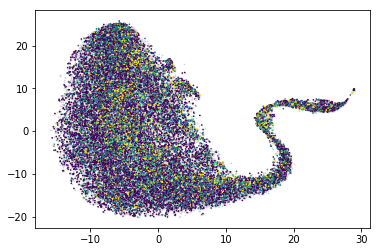

In [2]:
with loompy.connect("/Users/stelin/L1_OligoPons.loom") as ds:
    gene = "Sox10"
    plt.scatter(ds.ca._X,ds.ca._Y,s=10,lw=0,marker='.',c="lightgrey")
    cells = ds[ds.ra.Gene == gene, :][0] > 0
    color = ds[ds.ra.Gene == gene, :][0][cells]
    plt.scatter(ds.ca._X[cells],ds.ca._Y[cells],s=10,lw=0,vmax=np.percentile(color, 95),marker='.',c=color)


In [3]:
celltypes = ["OPC", "COP1", "COP2", "NFOL1", "NFOL2", "MFOL1", "MFOL2", "MOL1", "MOL2", "MOL3"]
with loompy.connect("/Users/sten/build_20171205/L5_All.agg.loom") as ds:
    genes = []
    for ct in celltypes:
        ix = np.where(ds.ca.ClusterName == ct)[0]
        enrichment = ds["enrichment"][:, ix][:,0]
        genes += list(np.argsort(-enrichment)[:100])
    genes = np.sort(ds.ra.Gene[np.unique(genes)])


In [4]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gene_ids = np.where(np.isin(ds.ra.Gene, genes))[0]
    genes = ds.ra.Gene[gene_ids]
    data = ds[gene_ids, :]

In [12]:
%%time
STEP = 16
d = data[:, ::STEP].transpose()
am = cg.AbsoluteManifold(radius=3, metric="variance_stabilized")
am.fit(d)

CPU times: user 6min 3s, sys: 1 s, total: 6min 4s
Wall time: 6min 5s


/Users/stelin/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


##### Using the "variance_stabilized" metric
```
64 -> 22 s
32 -> 1 min 22 s
16 -> 6 min 5 s
```

In [12]:
data_adj = (np.sqrt(data) + 0.8 * np.sqrt(data + 1)) / 1.8
sums = np.sum(data_adj, axis=0)
data_adj = data_adj / sums * np.median(sums)

/Users/stelin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [52]:
bt = BallTree(data_adj.T)
nn = bt.query(data_adj.T, k=10)


In [55]:
a = data[0][:8193].copy()
#a[8192] = 1
np.sqrt(a)


/Users/stelin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.7320508, 1.4142135, 0.       , ..., 0.       , 0.       ,
       1.       ], dtype=float32)

(array([0, 0, 0, ..., 0, 0, 0]), array([   25,    68,   522, ..., 35505, 35962, 36402]))


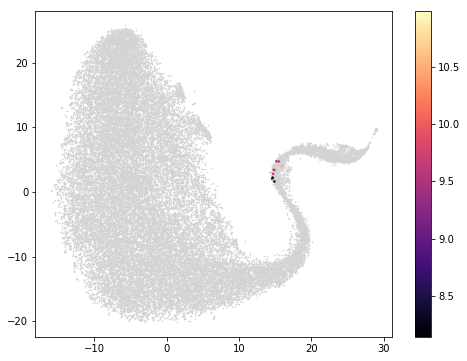

In [105]:
STEP = 1
N = d.shape[0]
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    print(np.where(ds[ds.ra.Gene == "Bmp4", :]>0))
    #print(ds.ca.keys())
    plt.figure(figsize=(8,6))
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    selected = nn[1][69,:]
    cax=plt.scatter(ds.ca._X[selected],ds.ca._Y[selected],s=25,vmin=np.percentile(nn[0][:,1], 1),vmax=np.percentile(nn[0][:,1], 99),cmap="magma",lw=0,marker='.',c=nn[0][:,1][selected])
    plt.colorbar(cax)

In [5]:
xy = umap.UMAP(n_neighbors=25, min_dist=0.01, metric=cg.stabilized_minkowski).fit_transform(data.T)

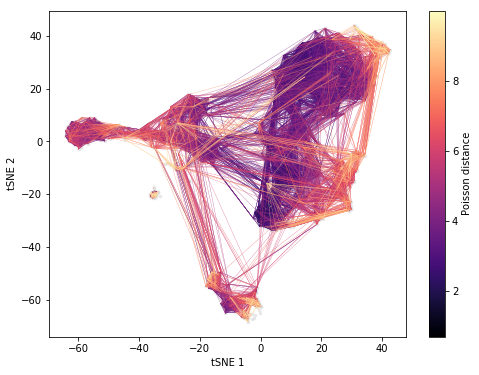

In [261]:
#f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    xy=ds.ca.TSNE
    knn=ds.col_graphs.KNN
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plt.scatter(xy[:,0],xy[:,1],s=50,lw=0,marker='.',c="lightgrey",alpha=0.5)
    colors = plt.cm.magma(knn.data / knn.data.max())
    ordering = np.argsort(knn.data)
    lc = LineCollection(zip(xy[knn.row][ordering], xy[knn.col][ordering]), linewidths=0.25, zorder=10, color=colors[ordering])
    ax.add_collection(lc)
    lc.set_array(np.sort(knn.data))
    lc.set_cmap("magma")
    cbar = plt.colorbar(lc)
    cbar.set_label("Poisson distance")
    plt.xlabel("tSNE 1")
    plt.ylabel("tSNE 2")

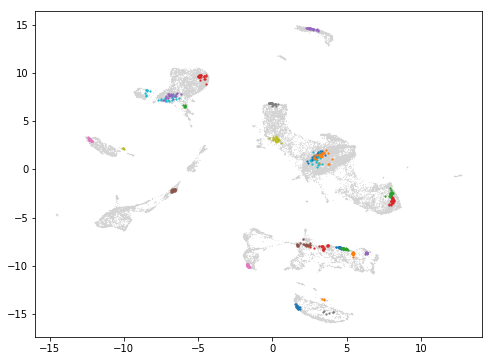

In [262]:
with loompy.connect("/Users/stelin/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=50_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom") as ds:
    knn = ds.col_graphs.KNN
    xy = ds.ca.UMAP
    plt.figure(figsize=(8,6))
    plt.scatter(x=xy[:,0], y=xy[:,1],c="lightgrey",s=5,alpha=0.5,lw=0,marker=".")
    for ix in [0,100, 250, 500, 1000, 2500,3000,4000,5000, 6000, 7500, 8000, 9000, 10000, 12000, 14500, 15000,16000,17000, 19000,20000, 22000, 25000, 27900, 29000]:
        neighbors = knn.col[knn.row == ix]
        plt.scatter(x=xy[:,0][neighbors], y=xy[:,1][neighbors],s=5,lw=0)

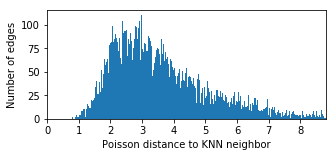

In [239]:
#f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"

with loompy.connect(f) as ds:
    knn = ds.col_graphs.KNN
    vals = knn.data[knn.data > 0]
    plt.figure(figsize=(5,2))
    plt.hist(vals, bins=1000)
    plt.xlim(0,np.percentile(vals,99))
    plt.ylabel("Number of edges")
    plt.xlabel("Poisson distance to KNN neighbor")

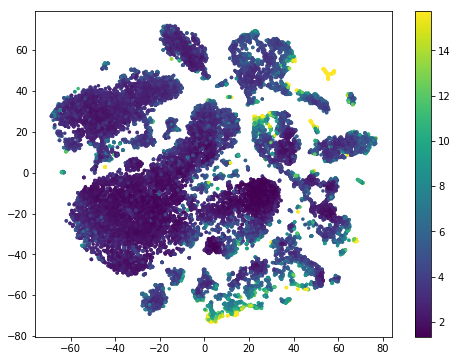

In [206]:
f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
#f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    xy=ds.ca.TSNE
    knn=ds.col_graphs.KNN
    k = knn.count_nonzero() / knn.shape[0]
    mu = knn.max(axis=1).T.A[0]
    fig = plt.figure(figsize=(8,6))
    cax=plt.scatter(xy[:,0],xy[:,1],s=50,lw=0,marker='.',c=mu,vmin=np.percentile(mu,1),vmax=np.percentile(mu,99))
#    cax=plt.scatter(xy[:,0],xy[:,1],s=50,lw=0,marker='.',c=totals,vmin=np.percentile(totals,0),vmax=np.percentile(totals,70),cmap="viridis_r")
    plt.colorbar(cax)

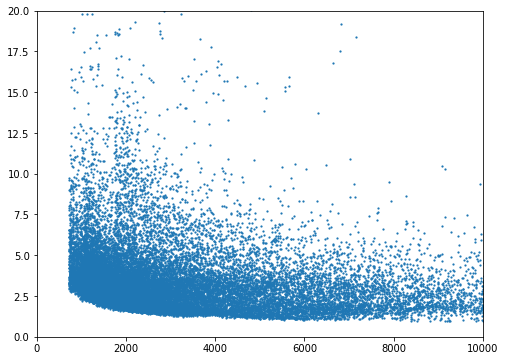

In [183]:
f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
#f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    xy=ds.ca.TSNE
    knn=ds.col_graphs.KNN
    k = knn.count_nonzero() / knn.shape[0]
    mu = knn.sum(axis=1).T.A[0] / k
    totals = ds.map([np.sum], axis=1)[0]
    fig = plt.figure(figsize=(8,6))
    cax=plt.scatter(totals,mu,s=20,lw=0,marker='.')
    #plt.xscale("log")
    #plt.yscale("log")
    plt.ylim(0,20)
    plt.xlim(0,10000)

In [202]:
f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
#f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    knn = ds.col_graphs.KNN
    s = (knn.data < 10) & (knn.data > 0)
    knn = sparse.coo_matrix((knn.data[s], (knn.row[s], knn.col[s])))

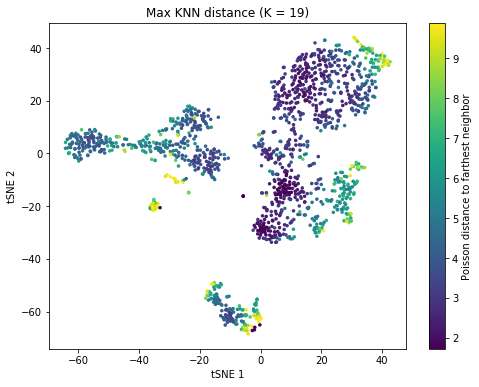

In [237]:
#f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
f = "/Users/sten/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    xy=ds.ca.TSNE
    knn=ds.col_graphs.KNN
    k = knn.count_nonzero() / knn.shape[0]
    knn.setdiag(1)
    mu = knn.max(axis=1).T.A[0]
    fig = plt.figure(figsize=(8,6))
    cax=plt.scatter(xy[:,0],xy[:,1],s=50,lw=0,marker='.',c=mu,vmin=np.percentile(mu,1),vmax=np.percentile(mu,99))
    plt.scatter(xy[:,0][mu > 10],xy[:,1][mu > 10],s=50,lw=0,marker='.',c='red',vmin=np.percentile(totals,0),vmax=np.percentile(totals,70),cmap="viridis_r")
    cbar=plt.colorbar(cax)
    cbar.set_label("Poisson distance to farthest neighbor")
    plt.ylabel("tSNE 2")
    plt.xlabel("tSNE 1")
    plt.title(f"Max KNN distance (K = {int(k)})")

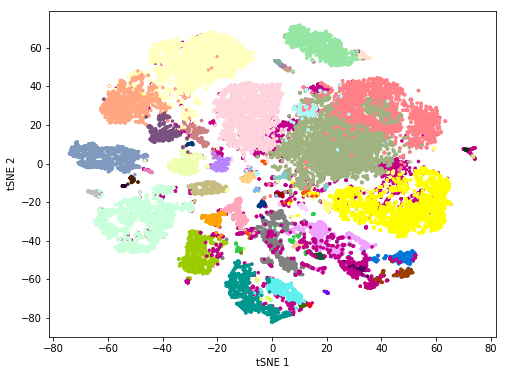

In [267]:
#f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=25_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
f = "/Users/sten/build_20171205/L1_Hippocampus_nfactors=100_k=25_ksmoothing=50_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
with loompy.connect(f) as ds:
    xy=ds.ca.TSNE
    knn=ds.col_graphs.KNN
    k = knn.count_nonzero() / knn.shape[0]
    knn.setdiag(1)
    mu = knn.max(axis=1).T.A[0]
    fig = plt.figure(figsize=(8,6))
    plt.scatter(xy[:,0],xy[:,1],s=50,lw=0,marker='.',c=cg.colorize(ds.ca.Clusters))
    plt.ylabel("tSNE 2")
    plt.xlabel("tSNE 1")

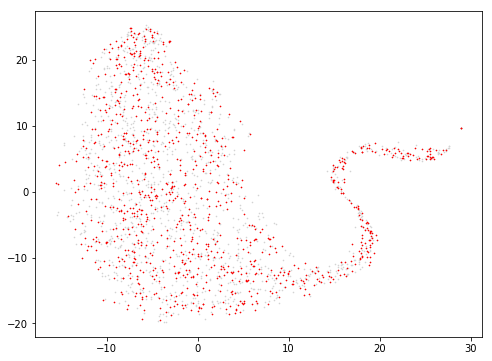

In [15]:
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    #print(np.where(ds[ds.ra.Gene=="Pdgfra", :]>0))
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    sample = am.sample(N=1000, pseudocounts=10)
    plt.scatter(ds.ca._X[::STEP][sample],ds.ca._Y[::STEP][sample],s=10,vmin=0,cmap="viridis",lw=0,marker='.',c='red')

In [12]:
smoothened = am.smoothen(normalize=True)

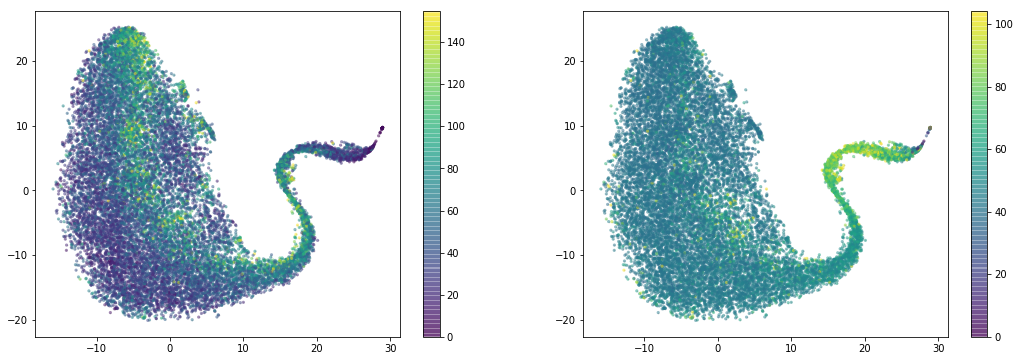

In [13]:
gene = "Mbp"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(am.data[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=am.data[:,gix])
    plt.colorbar(cax)
    
    plt.subplot(1,2,2)
    plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=10,lw=0,marker='.',c="lightgrey")
    cax=plt.scatter(ds.ca._X[::STEP],ds.ca._Y[::STEP],s=40,alpha=0.5,vmin=0,vmax=np.percentile(smoothened[:,gix],99),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix])
    plt.colorbar(cax)

In [58]:
xy = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      n_components=2,
                      metric=cg.poisson_distance_variance_stabilized
              ).fit_transform(data_adj.T)

AttributeError: module 'umap' has no attribute 'UMAP'

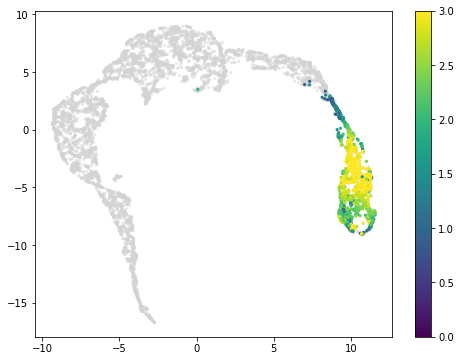

In [17]:
gene = "Itpr2"
with loompy.connect("/Users/sten/L1_OligoPons.loom") as ds:
    gix = np.where(genes == gene)[0][0]
    plt.figure(figsize=(8,6))
    plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,lw=0,marker='.',
                    c="lightgrey")

    cells = smoothened[:,gix][selected] > 0.8
    cax=plt.scatter(xy[:,0][cells],xy[:,1][cells],s=40,alpha=1,vmin=0,vmax=np.percentile(am.data[:,gix][selected],95),cmap="viridis",lw=0,marker='.',
                    c=smoothened[:,gix][selected][cells])
    plt.colorbar(cax)

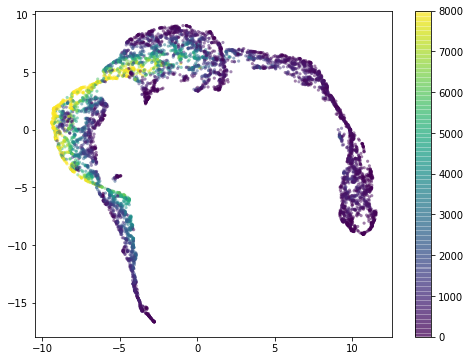

In [18]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=8000,cmap="viridis",lw=0,marker='.',c=am.n_neighbors[selected])
plt.colorbar(cax)

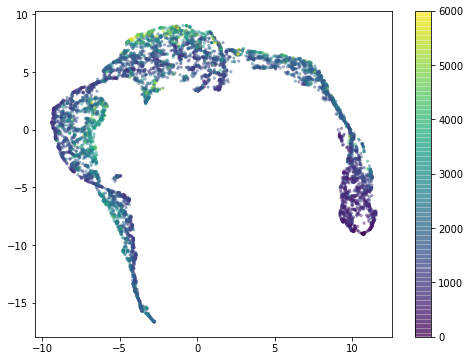

In [19]:
plt.figure(figsize=(8,6))
cax=plt.scatter(xy[:,0],xy[:,1],s=40,alpha=0.5,vmin=0,vmax=6000,cmap="viridis",lw=0,marker='.',c=am.data.sum(axis=1)[selected])
plt.colorbar(cax)